In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-08-02 12:15:25.264273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
image_path = '../dados/CAPTCHA-10k/teste'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,009001.jpg,JW4CZF
1,009002.jpg,H27LCM
2,009003.jpg,1EF8W0
3,009004.jpg,HZ1HQE
4,009005.jpg,97CZ9Z


In [4]:
vocab = [ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ']']
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ']'],
      dtype='<U1')

In [5]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [6]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  X = X.astype('float32') / 255.
  return X,df['txt_content']

X_teste,labels_teste = generate_X_Y('../dados/CAPTCHA-10k/teste')

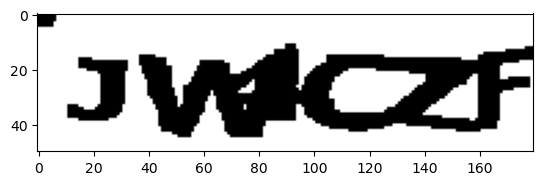

In [7]:
plt.imshow(X_teste[0], cmap='gray')

In [8]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [9]:
autoencoder = tf.keras.models.load_model('model_MSE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})
classifier = tf.keras.models.load_model('classifier_full_trained.tf')

2024-08-02 12:15:27.695804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13926 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


2024-08-02 12:15:30.880682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-08-02 12:15:31.535095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


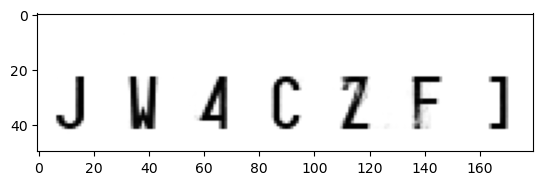

In [10]:
plt.imshow(autoencoder(X_teste[:1])[0],cmap="grey")

In [11]:
def inference(input_images):
    # Forward pass through the autoencoder
    autoencoder_output = autoencoder.predict(input_images)
    predictions_list = []

    interval = [0, 25, 50, 75, 100, 125, 150, 175]

    for i in range(len(interval) - 1):
        fake_img = autoencoder_output[:, :, interval[i]:interval[i + 1], :]
        y_pred = classifier(fake_img, training=False)
        predictions_list.append(y_pred)

    # Concatenate predictions from all patches
    predictions = tf.stack(predictions_list,axis=1)
    predictions = tf.argmax(predictions, axis=2)  # Convert to class indices
    return predictions.numpy()

preds = inference(X_teste)

32/32 [==============================] - 3s 41ms/step


In [12]:
vocab_tensor = np.array(vocab)

In [13]:
all_preds = vocab_tensor[preds]
words = ["".join(list(word)) for word in all_preds]
words = [w.replace("]","") for w in words]
df["preds"] = words

In [14]:
df.head()

,jpg_file,txt_content,preds
0,009001.jpg,JW4CZF,JW4CZF
1,009002.jpg,H27LCM,H27LCM
2,009003.jpg,1EF8W0,IEF8W0
3,009004.jpg,HZ1HQE,HZ1HQE
4,009005.jpg,97CZ9Z,97CZ9Z


In [15]:
def count_matches(row):
    txt_content = row['txt_content']
    pred = row['preds']
    return sum(1 for a, b in zip(txt_content, pred) if a == b)

# Apply the function to each row
df['matches'] = df.apply(count_matches, axis=1)
df.sort_values(by="matches").head(20)

,jpg_file,txt_content,preds,matches
66,009067.jpg,WMB8YMN,WMBYMN,3
979,009980.jpg,S0GBOX,SOG8OK,3
29,009030.jpg,UL0PO1,LLOPOU,3
807,009808.jpg,OSXCZO,OBXOZC,3
536,009537.jpg,VW4ECR,VVZEGR,3
493,009494.jpg,9WLHPM,OVMHPM,3
511,009512.jpg,WL92WN,WF92V?,3
808,009809.jpg,NMKZU1,NMXZUA,4
514,009515.jpg,YT8WLB,YT8WV8,4
497,009498.jpg,XIW4T0,XTW?T0,4


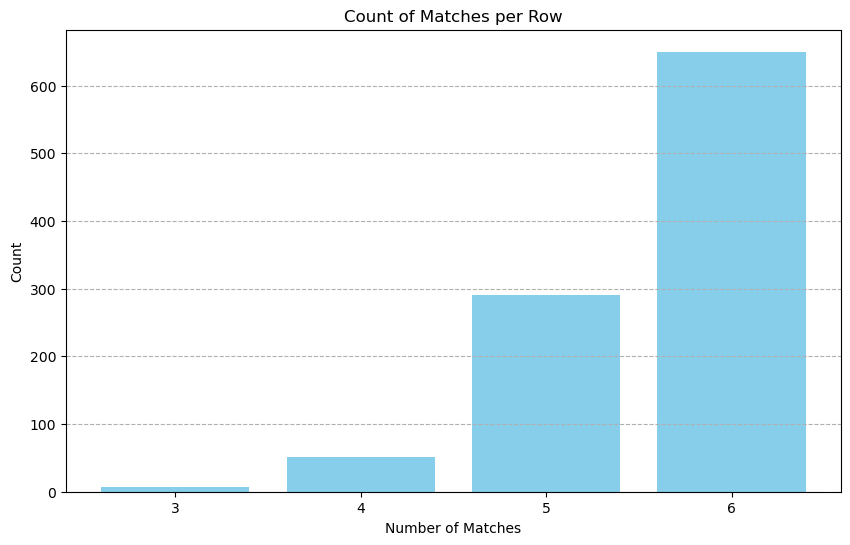

In [16]:
match_counts = df['matches'].value_counts().sort_index()

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(match_counts.index, match_counts.values, color='skyblue')
plt.xlabel('Number of Matches')
plt.ylabel('Count')
plt.title('Count of Matches per Row')
plt.xticks(match_counts.index)  # Ensure x-axis labels match the match counts
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

In [20]:
miss = (df["matches"] != df["txt_content"].str.len()).sum()
acc = (len(df) - miss)/len(df)
acc

0.65

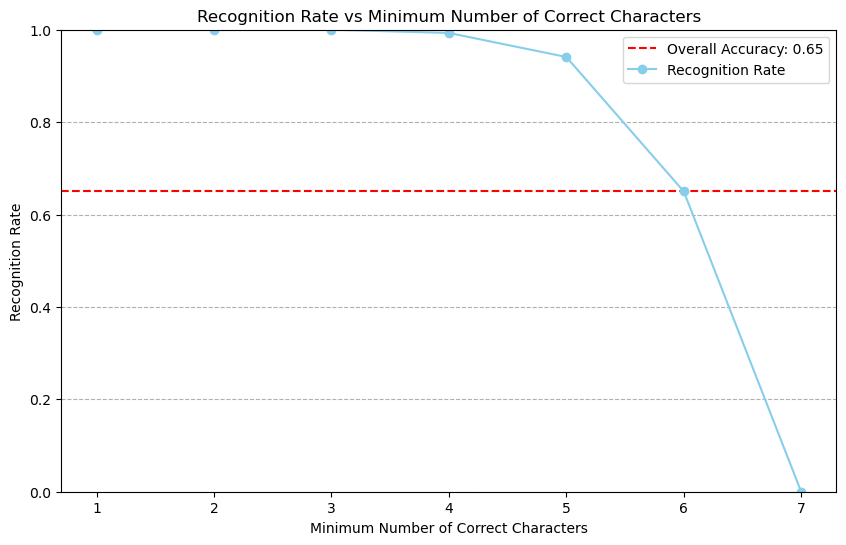

In [18]:
# Calculate recognition rates
max_chars = df['txt_content'].map(len).max()
recognition_rates = []

for min_correct in range(1, max_chars + 1):
    count_correct = df['matches'] >= min_correct
    rate = count_correct.mean()
    recognition_rates.append(rate)

# Plot the recognition rates
plt.figure(figsize=(10, 6))
plt.axhline(y=acc, color='r', linestyle='--', label=f'Overall Accuracy: {acc:.2f}')
plt.plot(range(1, max_chars + 1), recognition_rates, marker='o', color='skyblue', label='Recognition Rate')
plt.xlabel('Minimum Number of Correct Characters')
plt.ylabel('Recognition Rate')
plt.title('Recognition Rate vs Minimum Number of Correct Characters')
plt.grid(axis='y', linestyle='--')
plt.ylim(0, 1)
plt.xticks(range(1, max_chars + 1))
plt.legend()
plt.show()